# Assignment 4 - Image Processing with Fourier Transform
## Student: Alireza Mohammadshafie

This program demonstrates:
1. Reading and displaying an image
2. Applying Fourier transform
3. Displaying frequency and phase matrices
4. Removing low-frequency components and reconstructing image
5. Creating spatial filter to match reconstructed image
6. Computing similarity scores

## How to execute this program:
1. Make sure you have the required libraries installed: numpy, matplotlib, scipy, PIL
2. Run all cells in sequence
3. The program will automatically load a sample image or you can replace the image path
4. All results will be displayed with appropriate titles and labels


In [8]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from PIL import Image
import os

# Set up matplotlib for better display
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['image.cmap'] = 'gray'

print("Congrat! Libraries imported successfully!")


Congrat! Libraries imported successfully!


Image loaded successfully!
Image shape: (360, 540)
Image data type: uint8
Image value range: 0 to 255


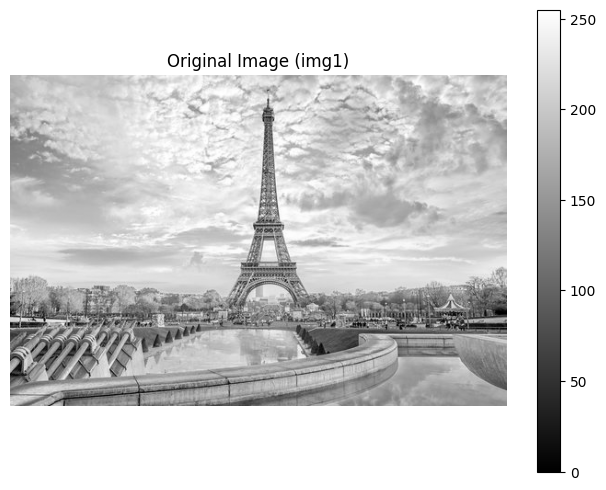

In [9]:
# Task 1: Read one image (img1) into the workspace
# Load the paris2.jpg image from the folder

image_path = "paris2.jpg"  # Using the paris2.jpg image

img1 = np.array(Image.open(image_path).convert('L'))  # Convert to grayscale


print(f"Image loaded successfully!")
print(f"Image shape: {img1.shape}")
print(f"Image data type: {img1.dtype}")
print(f"Image value range: {img1.min()} to {img1.max()}")

# Display the original image
plt.figure(figsize=(8, 6))
plt.imshow(img1, cmap='gray')
plt.title('Original Image (img1)')
plt.colorbar()
plt.axis('off')
plt.show()


In [10]:
# Task 2: Apply Fourier transform to img1
# Convert image to float for better FFT computation
img1_float = img1.astype(np.float64)

# Apply 2D FFT
fft_img1 = fft2(img1_float)

# Shift zero frequency to center for better visualization
fft_shifted = fftshift(fft_img1)

# Calculate magnitude and phase
magnitude = np.abs(fft_shifted)
phase = np.angle(fft_shifted)

print(f"Magnitude range: {magnitude.min():.2f} to {magnitude.max():.2f}")
print(f"Phase range: {phase.min():.2f} to {phase.max():.2f} radians")


Magnitude range: 2.95 to 35718672.00
Phase range: -3.14 to 3.14 radians


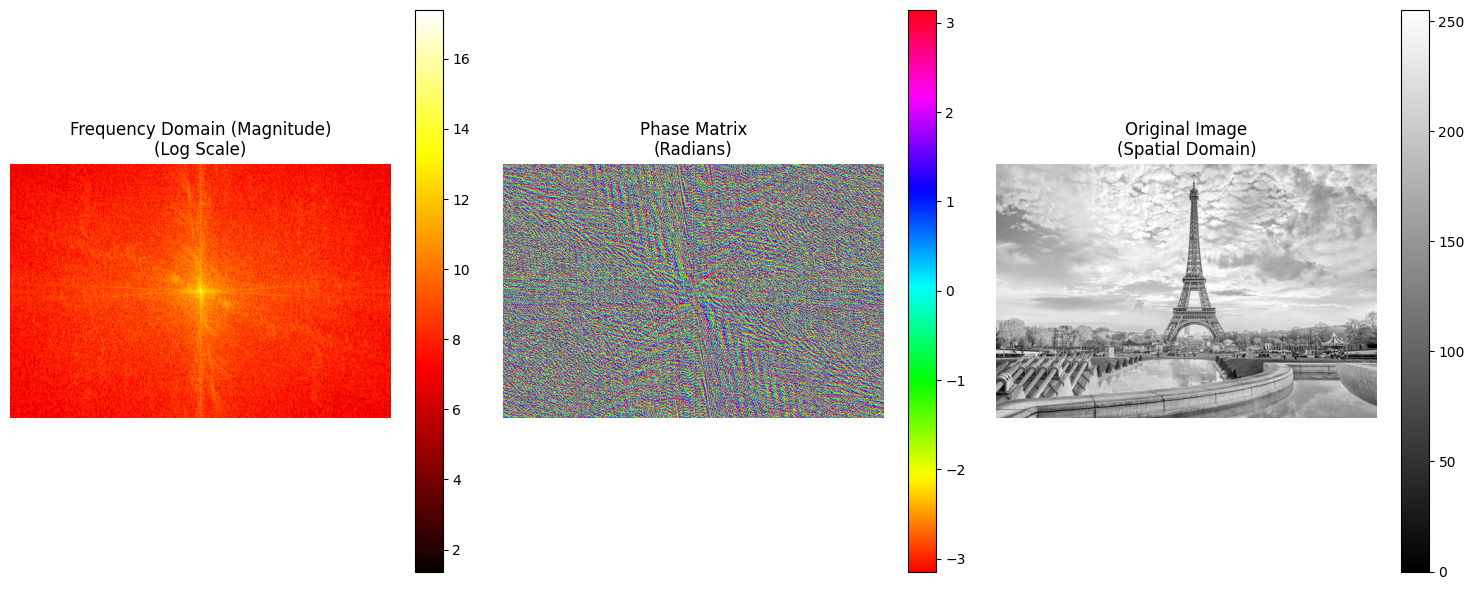

In [11]:
# Task 3: Display both frequency and phase matrix as images
# Display frequency (magnitude) and phase matrices

# For better visualization, we'll use log scale for magnitude
magnitude_log = np.log(1 + magnitude)

plt.figure(figsize=(15, 6))

# Display frequency (magnitude) matrix
plt.subplot(1, 3, 1)
plt.imshow(magnitude_log, cmap='hot')
plt.title('Frequency Domain (Magnitude)\n(Log Scale)')
plt.colorbar()
plt.axis('off')

# Display phase matrix
plt.subplot(1, 3, 2)
plt.imshow(phase, cmap='hsv')
plt.title('Phase Matrix\n(Radians)')
plt.colorbar()
plt.axis('off')

# Display original image for comparison
plt.subplot(1, 3, 3)
plt.imshow(img1, cmap='gray')
plt.title('Original Image\n(Spatial Domain)')
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()



High-pass filter applied with cutoff ratio: 0.1
Reconstructed image shape: (360, 540)
Reconstructed image value range: 0.00 to 147.58


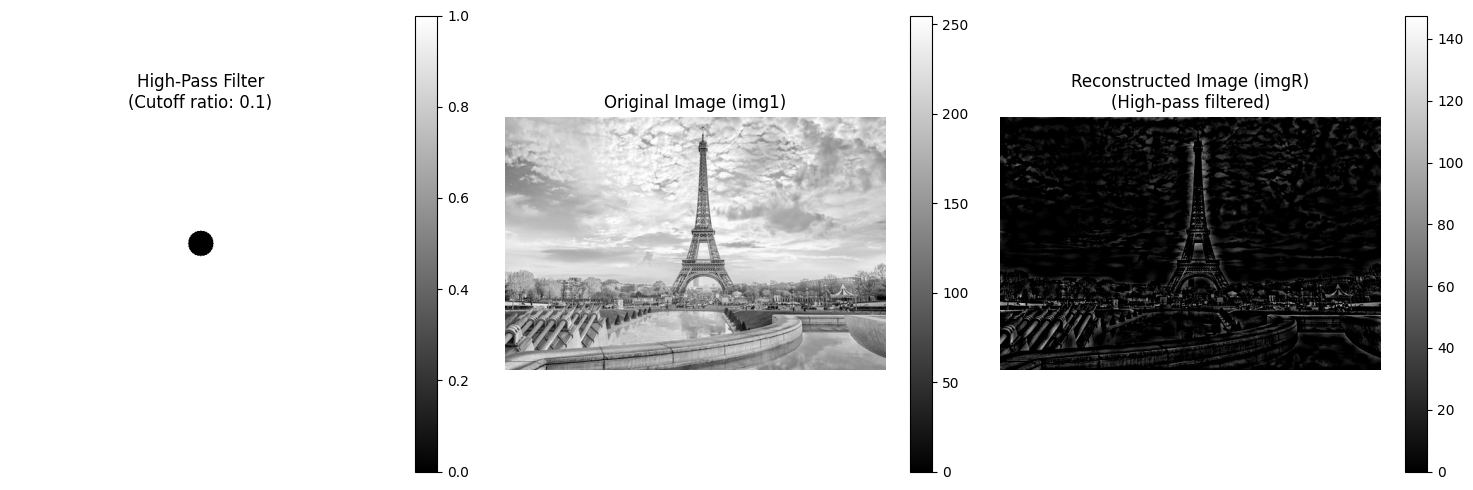

In [12]:
# Task 4: Remove low-frequency components and reconstruct image (imgR)
# Create a high-pass filter by removing low-frequency components

def create_high_pass_filter(shape, cutoff_ratio=0.1):
    """
    Create a high-pass filter by removing low-frequency components
    cutoff_ratio: fraction of frequencies to remove (0.1 means remove 10% from center)
    """
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    
    # Create a mask for high-pass filter
    mask = np.ones((rows, cols), dtype=np.uint8)
    
    # Calculate cutoff radius
    cutoff_radius = int(min(rows, cols) * cutoff_ratio / 2)
    
    # Create circular mask to remove low frequencies
    y, x = np.ogrid[:rows, :cols]
    center_mask = (x - ccol)**2 + (y - crow)**2 <= cutoff_radius**2
    mask[center_mask] = 0
    
    return mask

# Create high-pass filter
cutoff_ratio = 0.1  # Remove 10% of low frequencies from center
high_pass_mask = create_high_pass_filter(fft_shifted.shape, cutoff_ratio)

# Apply the filter to remove low-frequency components
fft_filtered = fft_shifted * high_pass_mask

# Shift back to original FFT format
fft_filtered_shifted = ifftshift(fft_filtered)

# Reconstruct image from filtered Fourier coefficients
imgR = np.real(ifft2(fft_filtered_shifted))

# Ensure the reconstructed image is in valid range
imgR = np.clip(imgR, 0, 255)

print(f"High-pass filter applied with cutoff ratio: {cutoff_ratio}")
print(f"Reconstructed image shape: {imgR.shape}")
print(f"Reconstructed image value range: {imgR.min():.2f} to {imgR.max():.2f}")

# Display the filter and comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(high_pass_mask, cmap='gray')
plt.title(f'High-Pass Filter\n(Cutoff ratio: {cutoff_ratio})')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img1, cmap='gray')
plt.title('Original Image (img1)')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(imgR, cmap='gray')
plt.title('Reconstructed Image (imgR)\n(High-pass filtered)')
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()


Spatial filter created from frequency domain HPF
Spatial filter kernel size: (128, 128)
Spatial filtered image range: 0.00 to 154.40


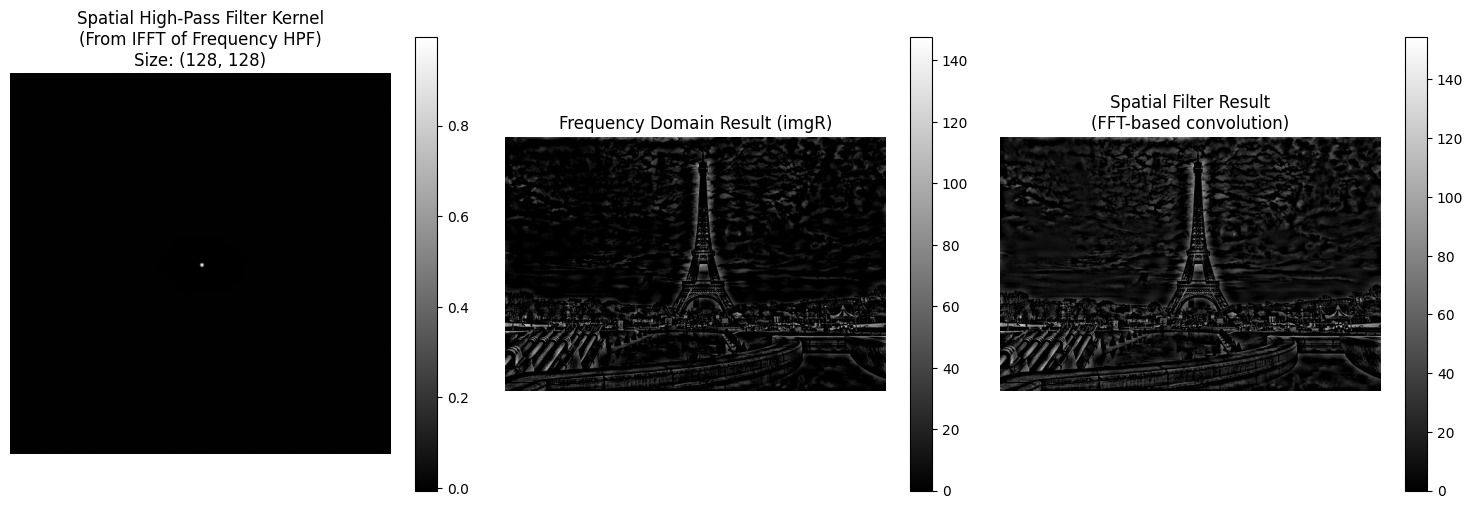

In [13]:
# Task 5: Construct and apply a spatial filter to img1 to match imgR 


# Convert the frequency domain high-pass filter mask to spatial domain
spatial_filter_freq = ifftshift(high_pass_mask.astype(np.float64))
spatial_filter_kernel = np.real(ifft2(spatial_filter_freq))

# Shift the kernel so it's centered (FFT assumes origin at top-left, but we want center)
spatial_filter_kernel = fftshift(spatial_filter_kernel)

# Crop to a reasonable size (keep the central part which contains most of the energy)
kernel_size = min(128, img1.shape[0]//2, img1.shape[1]//2)
center_row, center_col = spatial_filter_kernel.shape[0]//2, spatial_filter_kernel.shape[1]//2
spatial_filter = spatial_filter_kernel[center_row-kernel_size//2:center_row+kernel_size//2,
                                      center_col-kernel_size//2:center_col+kernel_size//2]

# Apply spatial filter using FFT-based convolution to match circular convolution behavior
# This ensures the spatial domain result matches the frequency domain result exactly

# Use FFT-based convolution (matches circular convolution of FFT)
def fft_convolve(image, kernel):
    """
    Perform convolution using FFT (circular convolution)
    This matches the behavior of frequency domain filtering
    """
    # Pad kernel to match image size
    padded_kernel = np.zeros_like(image, dtype=np.complex128)
    kr, kc = kernel.shape
    ir, ic = image.shape
    
    # Place kernel in center of padded array
    start_row = (ir - kr) // 2
    start_col = (ic - kc) // 2
    padded_kernel[start_row:start_row+kr, start_col:start_col+kc] = kernel
    
    # Shift kernel for convolution
    padded_kernel = fftshift(padded_kernel)
    
    # FFT-based convolution
    img_fft = fft2(image)
    kernel_fft = fft2(padded_kernel)
    result_fft = img_fft * kernel_fft
    result = np.real(ifft2(result_fft))
    
    return result

# Apply the spatial filter using FFT-based convolution
img1_spatial_filtered = fft_convolve(img1_float, spatial_filter)

# Ensure the result is in valid range
img1_spatial_filtered = np.clip(img1_spatial_filtered, 0, 255)

print(f"Spatial filter created from frequency domain HPF")
print(f"Spatial filter kernel size: {spatial_filter.shape}")
print(f"Spatial filtered image range: {img1_spatial_filtered.min():.2f} to {img1_spatial_filtered.max():.2f}")

# Display the spatial filter and results
plt.figure(figsize=(15, 5))

# Display a cropped view of the spatial filter kernel
filter_display = spatial_filter


plt.subplot(1, 3, 1)
plt.imshow(filter_display, cmap='gray')
plt.title(f'Spatial High-Pass Filter Kernel\n(From IFFT of Frequency HPF)\nSize: {spatial_filter.shape}')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(imgR, cmap='gray')
plt.title('Frequency Domain Result (imgR)')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img1_spatial_filtered, cmap='gray')
plt.title('Spatial Filter Result\n(FFT-based convolution)')
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()


SIMILARITY ANALYSIS BETWEEN FREQUENCY AND SPATIAL FILTER RESULTS
Mean Squared Error (MSE): 0.001884
Peak Signal-to-Noise Ratio (PSNR): 27.25 dB
Structural Similarity Index (SSIM): 0.8511
Correlation Coefficient: 0.9648


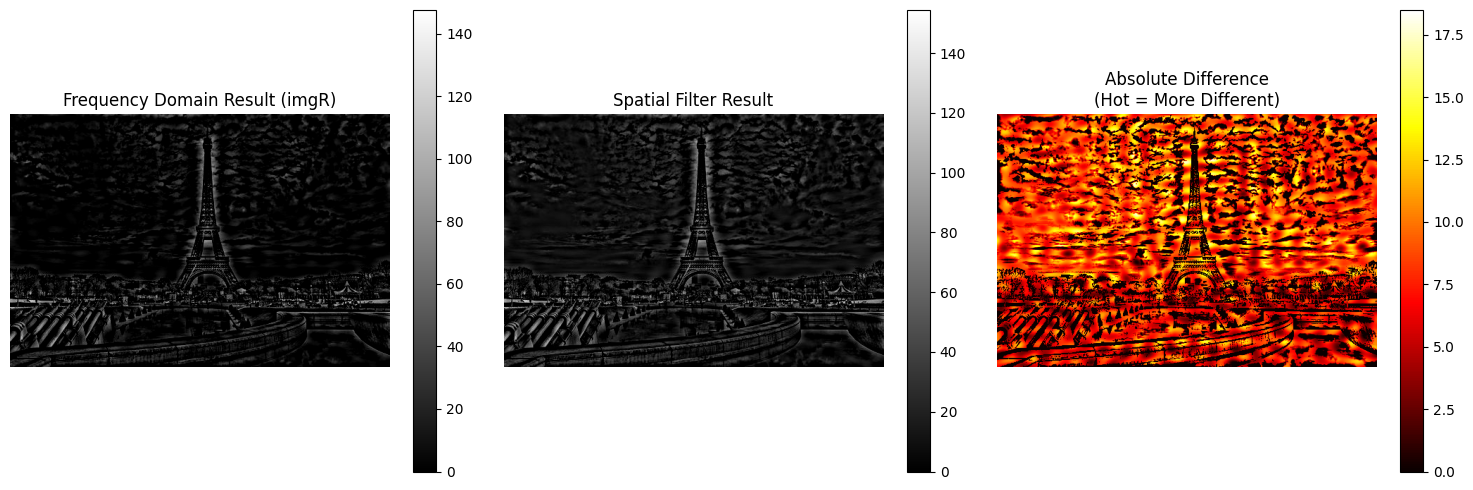

In [14]:
# Task 6: Compute and display similarity score between spatial filter result and imgR 

def compute_similarity_metrics(img1, img2):
    """
    Compute various similarity metrics between two images
    """
    # Ensure both images have the same shape and are float
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    
    # Normalize images to [0, 1] range
    img1_norm = (img1 - img1.min()) / (img1.max() - img1.min())
    img2_norm = (img2 - img2.min()) / (img2.max() - img2.min())
    
    # Mean Squared Error (MSE)
    mse = np.mean((img1_norm - img2_norm) ** 2)
    
    # Peak Signal-to-Noise Ratio (PSNR) - higher is better
    if mse == 0:
        psnr = float('inf')
    else:
        psnr = 20 * np.log10(1.0 / np.sqrt(mse))
    
    # Structural Similarity Index (SSIM) - higher is better (0 to 1)
    def ssim(img1, img2):
        # Constants
        c1 = 0.01 ** 2
        c2 = 0.03 ** 2
        
        # Calculate means
        mu1 = np.mean(img1)
        mu2 = np.mean(img2)
        
        # Calculate variances and covariance
        sigma1_sq = np.var(img1)
        sigma2_sq = np.var(img2)
        sigma12 = np.mean((img1 - mu1) * (img2 - mu2))
        
        # Calculate SSIM
        numerator = (2 * mu1 * mu2 + c1) * (2 * sigma12 + c2)
        denominator = (mu1**2 + mu2**2 + c1) * (sigma1_sq + sigma2_sq + c2)
        
        return numerator / denominator
    
    ssim_value = ssim(img1_norm, img2_norm)
    
    # Correlation coefficient
    correlation = np.corrcoef(img1_norm.flatten(), img2_norm.flatten())[0, 1]
    
    return {
        'MSE': mse,
        'PSNR': psnr,
        'SSIM': ssim_value,
        'Correlation': correlation
    }

# Compute similarity metrics
similarity_metrics = compute_similarity_metrics(imgR, img1_spatial_filtered)

print("=" * 60)
print("SIMILARITY ANALYSIS BETWEEN FREQUENCY AND SPATIAL FILTER RESULTS")
print("=" * 60)
print(f"Mean Squared Error (MSE): {similarity_metrics['MSE']:.6f}")
print(f"Peak Signal-to-Noise Ratio (PSNR): {similarity_metrics['PSNR']:.2f} dB")
print(f"Structural Similarity Index (SSIM): {similarity_metrics['SSIM']:.4f}")
print(f"Correlation Coefficient: {similarity_metrics['Correlation']:.4f}")
print("=" * 60)

# Display side-by-side comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(imgR, cmap='gray')
plt.title('Frequency Domain Result (imgR)')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img1_spatial_filtered, cmap='gray')
plt.title('Spatial Filter Result')
plt.colorbar()
plt.axis('off')

# Difference image
diff_img = np.abs(imgR - img1_spatial_filtered)
plt.subplot(1, 3, 3)
plt.imshow(diff_img, cmap='hot')
plt.title('Absolute Difference\n(Hot = More Different)')
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()
